# Getting started with MovingPanda

MovingPandas provides a trajectory datatype based on GeoPandas

https://github.com/anitagraser/movingpandas

In [1]:
%matplotlib inline

In [2]:
import urllib
import os
import pandas as pd
import movingpandas as mp
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta

## Creating a trajectory from scratch

Trajectory objects consist of a trajectory ID and a GeoPandas GeoDataFrame with a DatetimeIndex. The data frame therefore represents the trajectory data as a Pandas time series with associated point locations (and optional further attributes).

In [3]:
df = pd.DataFrame([
  {'geometry':Point(0,0), 't':datetime(2018,1,1,12,0,0)},
  {'geometry':Point(6,0), 't':datetime(2018,1,1,12,6,0)},
  {'geometry':Point(6,6), 't':datetime(2018,1,1,12,10,0)},
  {'geometry':Point(9,9), 't':datetime(2018,1,1,12,15,0)}
]).set_index('t')
geo_df = GeoDataFrame(df, crs={'init': '31256'})
toy_traj = mp.Trajectory(1, geo_df)
toy_traj.df

,geometry
t,
2018-01-01 12:00:00,POINT (0 0)
2018-01-01 12:06:00,POINT (6 0)
2018-01-01 12:10:00,POINT (6 6)
2018-01-01 12:15:00,POINT (9 9)


In [4]:
print(toy_traj)

Trajectory 1 (2018-01-01 12:00:00 to 2018-01-01 12:15:00) | Size: 4 | Length: 16.2m
Bounds: (0.0, 0.0, 9.0, 9.0)
LINESTRING (0 0, 6 0, 6 6, 9 9)


In [5]:
toy_traj.df

,geometry,prev_pt,dist_to_prev
t,,,
2018-01-01 12:00:00,POINT (0 0),NaN,0.000000
2018-01-01 12:06:00,POINT (6 0),POINT (0 0),6.000000
2018-01-01 12:10:00,POINT (6 6),POINT (6 0),6.000000
2018-01-01 12:15:00,POINT (9 9),POINT (6 6),4.242641


The notebook environment automatically plots Shapely geometry objects like the LineString returned by to_linestring() or the Point returned by get_position_at():

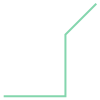

In [6]:
toy_traj.to_linestring()

In [7]:
toy_traj.add_speed()
toy_traj.df

,geometry,prev_pt,dist_to_prev,delta_t,speed
t,,,,,
2018-01-01 12:00:00,POINT (0 0),NaN,0.000000,NaT,0.016667
2018-01-01 12:06:00,POINT (6 0),POINT (0 0),6.000000,00:06:00,0.016667
2018-01-01 12:10:00,POINT (6 6),POINT (6 0),6.000000,00:04:00,0.025000
2018-01-01 12:15:00,POINT (9 9),POINT (6 6),4.242641,00:05:00,0.014142


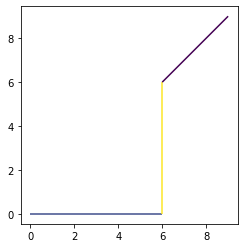

In [8]:
toy_traj.plot(column="speed")

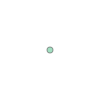

In [9]:
toy_traj.get_position_at(datetime(2018,1,1,12,6,0), method="nearest")    

In [10]:
print(toy_traj.get_position_at(datetime(2018,1,1,12,6,0), method="nearest"))

POINT (6 0)


## Extracting trajectory segments based on time or geometry (i.e. clipping)

First, let's extract the trajectory segment for a certain time period:

In [11]:
print(toy_traj.get_segment_between(datetime(2018,1,1,12,6,0),datetime(2018,1,1,12,12,0)))

Trajectory 1 (2018-01-01 12:06:00 to 2018-01-01 12:10:00) | Size: 2 | Length: 6.0m
Bounds: (6.0, 0.0, 6.0, 6.0)
LINESTRING (6 0, 6 6)


Now, let's extract the trajectory segment that intersects with a given polygon:

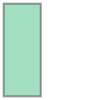

In [12]:
xmin, xmax, ymin, ymax = 2, 8, -10, 5
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])
polygon

In [13]:
intersection = toy_traj.clip(polygon)
print(intersection[0])

Trajectory 1_0 (2018-01-01 12:02:00 to 2018-01-01 12:09:20) | Size: 3 | Length: 9.0m
Bounds: (2.0, 0.0, 6.0, 5.0)
LINESTRING (2 0, 6 0, 6 5)


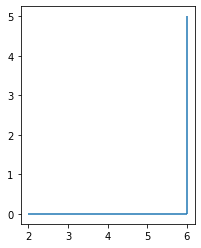

In [14]:
intersection[0].plot()

## Loading trajectory data from GeoPackage

The MovingPandas repository contains a demo GeoPackage file that can be loaded as follows:

In [15]:
url = 'https://github.com/anitagraser/movingpandas/raw/master/demo/demodata_geolife.gpkg'
filename = url.split('/')[-1] 

response = urllib.request.urlopen(url)
content = response.read()
with open(filename, 'wb' ) as f:
    f.write( content )


In [16]:
assert(os.path.exists(filename))

Now, we can use GeoPandas' read_file() function to read the GeoPackage and construct the Trajectories:

In [17]:
t_start = datetime.now()
df = read_file(filename)
df['t'] = pd.to_datetime(df['t'])
df = df.set_index('t')
print("Finished reading {} rows in {}".format(len(df),datetime.now() - t_start))

t_start = datetime.now()
trajectories = []
for key, values in df.groupby(['trajectory_id']):
    trajectory = mp.Trajectory(key, values)
    print(trajectory)
    trajectories.append(trajectory)
print("Finished creating {} trajectories in {}".format(len(trajectories),datetime.now() - t_start))

Finished reading 5908 rows in 0:00:00.332303
Trajectory 1 (2008-12-11 04:42:14+00:00 to 2008-12-11 05:15:46+00:00) | Size: 466 | Length: 6210.1m
Bounds: (116.385602, 39.862378, 116.393553, 39.898723)
LINESTRING (116.391305 39.898573, 116.391317 39.898617, 116.390928 39.898613, 116.390833 39.898635, 
Trajectory 2 (2009-06-29 07:02:25+00:00 to 2009-06-29 11:13:12+00:00) | Size: 897 | Length: 38728.7m
Bounds: (116.319212, 39.971703, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 
Trajectory 3 (2009-02-04 04:32:53+00:00 to 2009-02-04 11:20:12+00:00) | Size: 1810 | Length: 12739.2m
Bounds: (116.332706, 39.897023, 116.387307, 39.927949)
LINESTRING (116.385689 39.899773, 116.385654 39.899651, 116.385548 39.899699, 116.385527 39.899632, 
Trajectory 4 (2009-03-10 10:36:45+00:00 to 2009-03-10 12:01:07+00:00) | Size: 1864 | Length: 14357.6m
Bounds: (116.327347, 39.896671, 116.389611, 39.927947)
LINESTRING (116.388053 39.9

Let's look at one of those trajectories:

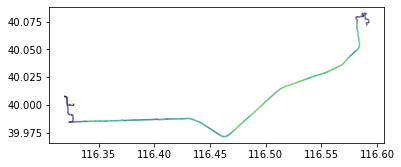

In [18]:
trajectories[1].plot(column='speed')

In [19]:
trajectories[1].plot_with_basemap(linewidth=3.0, figsize=(9,9))

AttributeError: 'Trajectory' object has no attribute 'plot_with_basemap'

## Finding intersections with a Shapely polygon

In [ ]:
xmin, xmax, ymin, ymax = 116.3685035,116.3702945,39.904675,39.907728
polygon = Polygon([(xmin,ymin), (xmin,ymax), (xmax,ymax), (xmax,ymin), (xmin,ymin)])

intersections = []
for key, values in df.groupby(['trajectory_id']):
    traj = mp.Trajectory(key, values)
    for intersection in traj.clip(polygon):
        intersections.append(intersection)
print("Found {} intersections".format(len(intersections)))

In [ ]:
intersections[2].plot()

## Splitting trajectories

Gaps are quite common in trajectories. For example, GPS tracks may contain gaps if moving objects enter tunnels where GPS reception is lost. In other use cases, moving objects may leave the observation area for longer time before returning and continuing their recorded track.

Depending on the use case, we therefore might want to split trajectories at observation gaps that exceed a certain minimum duration:

In [ ]:
print(trajectories[1])

In [ ]:
split = trajectories[1].split_by_observation_gap(timedelta(minutes=5))
for traj in split:
    print(traj)

In [ ]:
split[0].plot()

## Generalizing trajectories

To reduce the size of trajectory objects, we can generalize them, for example, using the Douglas-Peucker algorithm:

In [ ]:
trajectories[1].plot(column='speed')

Try different tolerance settings and observe the results in line geometry and therefore also length:

In [ ]:
generalized_traj = trajectories[1].generalize(mode='douglas-peucker', tolerance=0.001)
generalized_traj.plot(column='speed')

In [ ]:
print('Original length: %s'%(trajectories[1].get_length()))
print('Generalized length: %s'%(generalized_traj.get_length()))

In [ ]:
generalized_traj.df